# Aplicación del modelo de simulacion: Comparar el efecto del tiempo en un bloqueo

Especificamente, se tiene un bloqueo que se quiere hacer en el centro historico. Se evaluan distintos horarios en los que se puede hacer este bloqueo, corriendo simulaciones. Posteriormente se compara el efecto que tiene el bloqueo al hacerlo en distintos horarios. Manteniendo un enfoque estadistico riguroso, se hacen varias simulaciones y se usan pruebas estadisticas para sacar conclusiones

In [1]:
import numpy as np
import math
import networkx as nx
import pandas as pd
from tqdm import tqdm
import time
import pickle
import random
import colorsys
from matplotlib.ticker import MaxNLocator
from collections import Counter
import matplotlib.colors as mcolors
import os
import pickle
import copy
from scipy.spatial.distance import pdist, squareform
import gc
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from scipy.stats import shapiro, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# cargar el modelo
import simulation_model
from simulation_model import Modelo

In [4]:
# se van actualizando los resultados en 
carpeta_res  = ".\\Resultados_retrasos\\"
file_res = "retrasos.csv"

## Cargar centro historico

In [5]:
# carpeta donde se tiene la informacion del grafo
carpeta_datos = ".\\Datos_centro_historico\\"

In [6]:
# cargar el grafo del centro
with open(carpeta_datos + 'ejesviales_centro_graph.gpickle', 'rb') as f:
    G_centro = pickle.load(f)
    
print(f"Grafo del centro historico")
print(f"Numero de nodos:   {G_centro.number_of_nodes()}")
print(f"Numero de aristas: {G_centro.number_of_edges()}")

Grafo del centro historico
Numero de nodos:   18872
Numero de aristas: 20352


In [7]:
# cargar el pos
with open(carpeta_datos + 'ejesviales_centro_pos.pickle', 'rb') as f:
    pos_centro = pickle.load(f)

# ver que tenga de los nodos
print(f"Pos para {len(pos_centro)} nodos")

Pos para 18872 nodos


In [8]:
# definir probabilidades de origen
# primero se encuentra el posicion central
array_pos = np.array(list(pos_centro.values()))
pos_central = array_pos.mean(axis = 0)

# ahora por cada nodo calcular la distancia de su pos al pos central
# guardar en un dict
distancias_centro = {}
for nodo in G_centro.nodes():
  # solo hacer si tiene grado menor a 3
  if G_centro.degree(nodo) < 3:
    distancias_centro[nodo] = np.linalg.norm(np.array(pos_centro[nodo]) - pos_central)
  # sino, hacerlo 0
  else:
    distancias_centro[nodo] = 0

# normalizar para tener probabilidades
suma_distancias = sum(distancias_centro.values())
proba_origen_centro = {nodo : distancias_centro[nodo]/suma_distancias for nodo in G_centro.nodes()}

del distancias_centro

In [9]:
# cargar las probabilidades de destino
with open(carpeta_datos + 'proba_destino.pkl', 'rb') as f:
    proba_destino_centro = pickle.load(f)

# remplazar Nan con 0
proba_destino_centro = {k: (v if pd.notna(v) else 0) for k, v in proba_destino_centro.items()}

In [10]:
# poner todo esto en un dict
info_grafo_centro = {
    "G": G_centro,
    "pos": pos_centro,
    "proba_origen": proba_origen_centro,
    "proba_destino": proba_destino_centro
}

In [11]:
# argumentos de visualizacion
arg_visua_centro = {
    "node_size": 0.2,
    "edge_color": "gray",
    "arrowsize": 0.1,
    "color_vacio": '#f0f0f0',
    "color_bloqueo": "red",
    "color_atasco": "red"
}

## Filtrar un subgrafo del centro historico

Para un analisis mas localizado

In [12]:
# centrado en un nodo del bloqueo, pero que sea grande
subgrafo = nx.ego_graph(G_centro, 10871, radius=150, undirected=True)

print(f"Subgrafo a considerar")
print(f"Numero de nodos:   {subgrafo.number_of_nodes()}")
print(f"Numero de aristas: {subgrafo.number_of_edges()}")

Subgrafo a considerar
Numero de nodos:   6205
Numero de aristas: 6561


In [13]:
# poner la info en un dict
info_grafo_centro = {
    "G": subgrafo,
    "pos": pos_centro,
    "proba_origen": proba_origen_centro,
    "proba_destino": proba_destino_centro
}

## Delimitar el bloqueo

Hacer un bloqueo B, probar hacerlo en distintos horarios. Ver como afecta al retraso promedio de un agente.

In [14]:
# delimitar los bloqueos mismos todas las simulaciones
nodos_bloqueo = {12663, 8342, 3036, 1237, 9680, 10871, 13519, 6729, 6455, 10466, 10492, 7225, 11105}

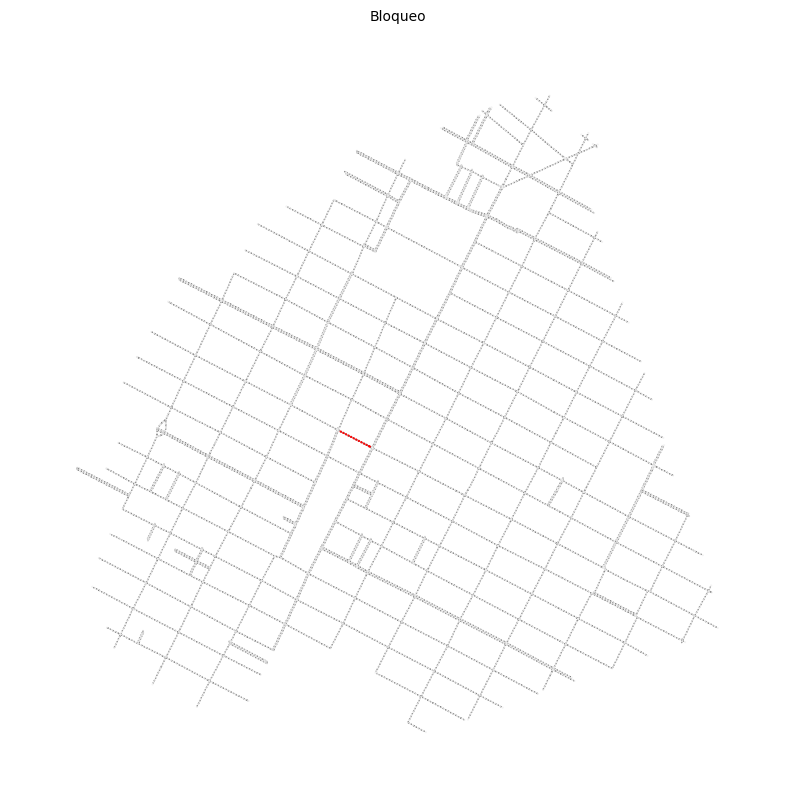

In [15]:
# modelo para ver
model_vis = Modelo(info_grafo_centro, argumentos_visualizacion = arg_visua_centro)
# ver bloqueo
fig, ax = plt.subplots(figsize=(10, 10))
model_vis.dibujar_path(list(nodos_bloqueo), color_path = "red", alpha_min = 0.3, ax=ax)
ax.set_title("Bloqueo", fontsize = 10)
plt.show()

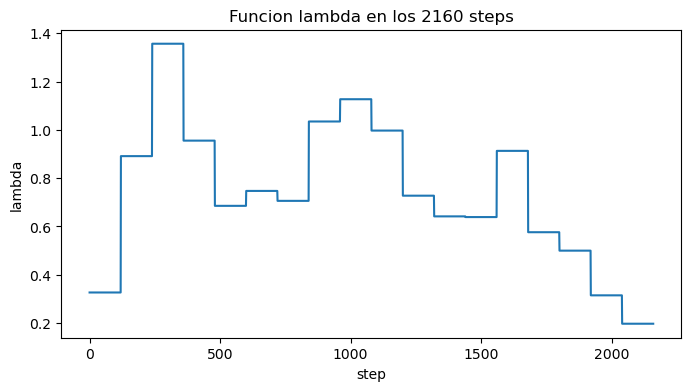

In [16]:
# constantes entre ambas simulaciones

# para controlar el tiempo
STEPS_PER_HORA = 120

# delimitar el numero de agentes en el modelo
NUM_AGENTES_TOTALES = 1600

# horas de toda la simulacion
HORA_INICIAL = 5
HORA_FINAL = 23

# Obtener numero de steps totales y funcion lambda
total_steps, funcion_lambda = simulation_model.get_total_steps_and_lambda_function(HORA_INICIAL = HORA_INICIAL,
                                                                                   HORA_FINAL = HORA_FINAL,
                                                                                   NUM_AGENTES_TOTALES = NUM_AGENTES_TOTALES,
                                                                                   STEPS_PER_HORA = STEPS_PER_HORA)


# ver la funcion lambda en todos los steps
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot([funcion_lambda(t) for t in range(total_steps)])
ax.set_xlabel("step")
ax.set_ylabel("lambda")
ax.set_title(f"Funcion lambda en los {total_steps} steps")
plt.show()

## Hacer el bloqueo en diferentes horarios

Se consideran cuatro horarios para el bloqueo:
* Horario h1 (5 am - 10 am)
* Horario h2 (7 am - 12 am)
* Horario h3 (3 pm - 8 pm)
* Horario h4 (5 pm - 10 pm)


Obtener muestras de las siguientes variables aleatorias

$$
X \sim \text{Retraso promedio de un agente al hacer el bloqueo en h1}
$$
$$
Y \sim \text{Retraso promedio de un agente al hacer el bloqueo en h2}
$$
$$
Z \sim \text{Retraso promedio de un agente al hacer el bloqueo en h3}
$$
$$
W \sim \text{Retraso promedio de un agente al hacer el bloqueo en h4}
$$

In [17]:
# delimitar los horarios de bloqueos
horarios = {"h1": (5, 10), "h2": (7, 12), "h3": (15, 20), "h4": (17, 22)}

# cuantas veces hacer simulaciones 
repeticiones = 2

In [18]:
# guardar resultados
resultados = {h : [] for h in horarios.keys()}

# por cada vez que se quieran hacer las 3 simulaciones
for idx in range(repeticiones):
    print(f"Repeticion {idx+1}")

    # por cada horario de bloqueo
    for h_i, horas in horarios.items():

        # calcular el step inicial y final usando las horas del bloqueo
        step_inicial_bloqueo = (horas[0] - HORA_INICIAL)*STEPS_PER_HORA
        step_final_bloqueo = (horas[1] - HORA_INICIAL)*STEPS_PER_HORA

        # delimitar el bloqueo para esta simulacion
        bloqueos_centro = [
            {
                "inicio_bloqueo": step_inicial_bloqueo,
                "fin_bloqueo": step_final_bloqueo,
                "nodos_bloqueados": nodos_bloqueo,
            }
        ]

        # hacer el modelo
        modelo = Modelo(info_grafo_centro, argumentos_visualizacion = arg_visua_centro)

        # correr la simulacion
        modelo.run_model(poblacion_inicial = 0,
                         lambda_tiempo = funcion_lambda,
                         steps_generando = total_steps,
                         steps_finales = 0,
                         visualizar= False,
                         sleep= 0,
                         ver_barra_progreso= True,
                         pesos_trafico = "simple",
                         tiempo_recalcular_agentes = 5,
                         bloqueos = bloqueos_centro)

        # obtener el retraso promeido de los agentes

        # solo considerar agentes que si llegaron a su destino
        agentes_modelo = [coche for coche in modelo.historico_agentes.values() if coche.tiempo_real < np.inf]
        # porcentaje de retraso de cada agente
        porcentaje_retraso = [100*agente.tiempo_real/agente.tiempo_minimo - 100 
                              for agente in agentes_modelo
                              if agente.tiempo_minimo != 0]

        # agregar a los resultados
        resultados[h_i].append(np.mean(porcentaje_retraso))
    print("-"*100)

Repeticion 1


Tiempos minimos:: 100%|██████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 1944.60it/s]


----------------------------------------------------------------------------------------------------
Repeticion 2


Tiempos minimos:: 100%|██████████████████████████████████████████████████████████| 1662/1662 [00:00<00:00, 2048.55it/s]

----------------------------------------------------------------------------------------------------


## Guardar resultados de estas pocas simulaciones

Por eficencia computacional, correr el programa solo hace pocas simulaciones.
Estas se añaden a los resultados totales, resultado de muchas ejecuciones

In [19]:
# hacer df de resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados.shape)
df_resultados.head()

(2, 4)


,h1,h2,h3,h4
0,1.283881,1.325132,1.353020,1.177704
1,1.242310,1.637537,1.444183,1.447889


In [20]:
# intenta cargar un archivo existente
try:

    # leer
    df = pd.read_csv(carpeta_res + file_res)
    # agregar nueva fila, con la info nueva
    df = pd.concat([df, df_resultados], ignore_index=True)
    df = df.fillna(0)
    # guardar el archivo modificado
    df.to_csv(carpeta_res + file_res, index=False)

# si no se puede abrir, no existe    
except FileNotFoundError:

    # guardar solo la info nueva
    df = df_resultados.fillna(0)
    df.to_csv(carpeta_res + file_res, index=False)

## Analizar resultados

Esto unicamente se hace hasta que el df creado en la seccion anterior sea lo suficientemente grande.


Se obtienen muestras

$$
X_1, X_2, \dots, X_n \quad \quad  \text{ i.i.d.} \quad X_i \sim X 
$$
$$
Y_1, Y_2, \dots, Y_n \quad \quad  \text{    i.i.d.} \quad Y_i \sim Y 
$$
$$
Z_1, Z_2, \dots, Z_n \quad \quad \text{i.i.d} \quad Z_i \sim Z 
$$
$$
W_1, W_2, \dots, W_n \quad \quad  \text{i.i.d} \quad W_i \sim W 
$$


In [21]:
# hacer df de resultados
print(df.shape)
df.head()

(30, 4)


,h1,h2,h3,h4
0,1.331194,1.408290,1.458523,1.361015
1,1.363488,1.343773,1.351160,1.315800
2,1.281391,1.497986,1.601394,1.250454
3,1.495366,1.474004,1.503905,1.180583
4,1.215524,1.373302,1.293851,1.374977


### 1) Estadistica descriptiva

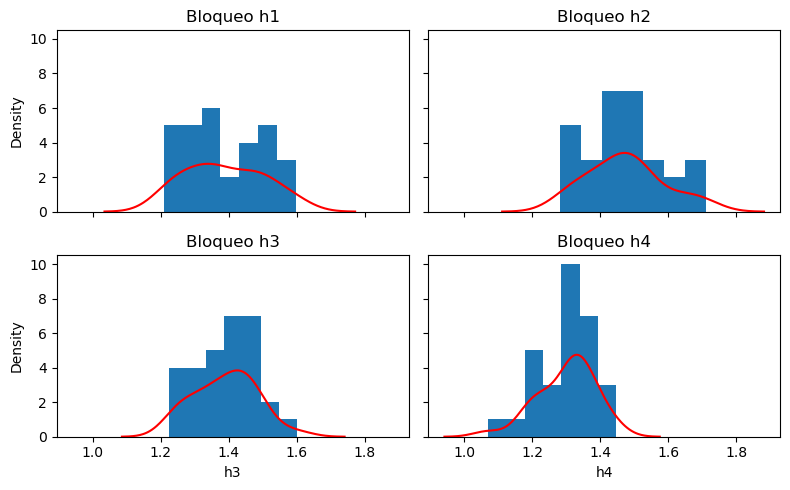

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), sharex = True, sharey=True)
num_bins = 7

# 1
ax[0, 0].hist(df["h1"], bins = num_bins)
sns.kdeplot(df["h1"], ax=ax[0, 0], color="red") 
ax[0, 0].set_title("Bloqueo h1")
          

# 2
ax[0, 1].hist(df["h2"], bins = num_bins)
sns.kdeplot(df["h2"], ax=ax[0, 1], color="red") 
ax[0, 1].set_title("Bloqueo h2")

# 3
ax[1, 0].hist(df["h3"], bins = num_bins)
sns.kdeplot(df["h3"], ax=ax[1, 0], color="red") 
ax[1, 0].set_title("Bloqueo h3")

# 4
ax[1, 1].hist(df["h4"], bins = num_bins)
sns.kdeplot(df["h4"], ax=ax[1, 1], color="red") 
ax[1, 1].set_title("Bloqueo h4")

plt.tight_layout()
plt.show()

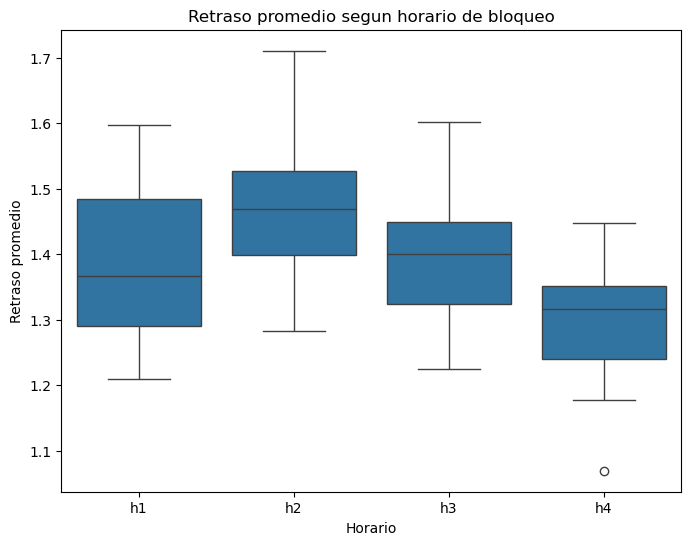

In [23]:
df_long = pd.melt(df, var_name='Horario', value_name='Retraso promedio')

# Creamos el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Horario', y='Retraso promedio')
plt.title('Retraso promedio segun horario de bloqueo')
plt.show()

### 2) Comprobar normalidad

Shapiro test

$$
H_0: \text{Los datos tienen distribucion normal} 
$$
$$
v.s
$$
$$
H_1: \text{Los datos no tienen distribucion normal}
$$


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [24]:
shapiro(df["h1"])

ShapiroResult(statistic=np.float64(0.9549845976563338), pvalue=np.float64(0.2294261921552907))

In [25]:
shapiro(df["h2"])

ShapiroResult(statistic=np.float64(0.9678035724581135), pvalue=np.float64(0.4809596510674948))

In [26]:
shapiro(df["h3"])

ShapiroResult(statistic=np.float64(0.9770696512955229), pvalue=np.float64(0.7434521150319786))

In [27]:
shapiro(df["h4"])

ShapiroResult(statistic=np.float64(0.962115317416761), pvalue=np.float64(0.3504357002245264))

### 3) Checar misma varianza

Levene test

$$
H_0: \text{Misma varianza en todas las poblaciones} 
$$
$$
v.s 
$$
$$
H_1: \text{No todas varianzas iguales}
$$


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

In [28]:
levene(df["h1"], df["h2"], df["h3"], df["h4"])

LeveneResult(statistic=np.float64(1.521870648007845), pvalue=np.float64(0.2125379875515849))

### 4) Diferencia entre grupuos

One-way ANOVA

$$
H_0: \text{Todas las medias son iguales} 
$$
$$
v.s 
$$
$$
H_1: \text{No todas las medias son iguales}
$$


Supuestos:
* Muestras independientes
* Distribuciones normales
* Misma varianza


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [29]:
f_oneway(df["h1"], df["h2"], df["h3"], df["h4"])

F_onewayResult(statistic=np.float64(14.586790340801171), pvalue=np.float64(4.004742771799428e-08))

### 5) Identificar diferencias

Tukey’s HSD


Mismos supuestos que one-way ANOVA

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.tukey_hsd.html

https://www.statsmodels.org/dev/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html

In [30]:
melted_df = df.melt()
posthoc_test = pairwise_tukeyhsd(melted_df['value'], melted_df['variable'], alpha = 0.05)
print(posthoc_test)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    h1     h2   0.0863 0.0073  0.0178  0.1548   True
    h1     h3   0.0019 0.9999 -0.0665  0.0704  False
    h1     h4  -0.0875 0.0063 -0.1559  -0.019   True
    h2     h3  -0.0843 0.0092 -0.1528 -0.0159   True
    h2     h4  -0.1737    0.0 -0.2422 -0.1053   True
    h3     h4  -0.0894  0.005 -0.1579 -0.0209   True
----------------------------------------------------


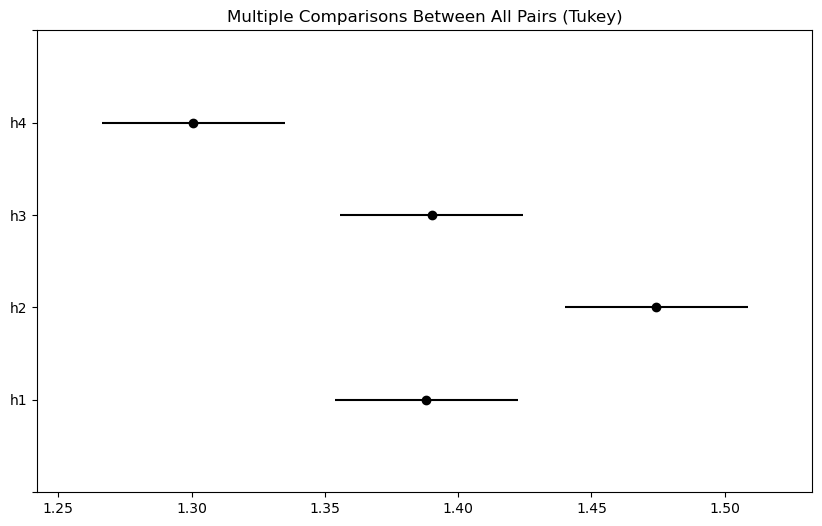

In [31]:
fig = posthoc_test.plot_simultaneous()

## Conclusiones

* El horario h4 (5 pm - 10 pm) causa el menor retraso
* El horario h2 (7 am - 12 am) causa el mayor retraso
* No hay diferencia entre hacer el bloqueo en h1 (5 am - 10 am) o h3 (3 pm - 8 pm)